#### Install dependencies

In [ ]:
!pip install transformers==2.11.0 -U tokenizers==0.7.0 -q

     |████████████████████████████████| 675kB 4.8MB/s 
     |████████████████████████████████| 3.8MB 23.2MB/s 
     |████████████████████████████████| 1.1MB 34.0MB/s 
     |████████████████████████████████| 890kB 55.7MB/s 


In [ ]:
!pip install scipy -q

In [ ]:
!git clone https://github.com/IgnatovD/image_captioning_CNN_RNN

Cloning into 'image_captioning_CNN_RNN'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 69 (delta 40), reused 47 (delta 18), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [ ]:
cd image_captioning_CNN_RNN

/content/image_captioning_CNN_RNN


In [ ]:
import json
import numpy as np

import random
from PIL import Image
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

from tokenizer import train_tokenizer
from data_processing import GetDataset, collate_fn
from model import Encoder, CaptionNet, ImgCap
from trainer import get_blue, train, evaluate
from beheaded_inception3 import beheaded_inception_v3

import warnings
warnings.filterwarnings('ignore')

#### Get data

In [ ]:
!mkdir -p data
!wget https://www.dropbox.com/s/qdcu37dg4w2adwy/handout.tar.gz?dl=0 -O data/handout.tar.gz -q

In [ ]:
!tar -xvf data/handout.tar.gz

data/
data/captions_tokenized.json
data/image_codes.npy


In [ ]:
img_codes = np.load('data/image_codes.npy')
captions = json.load(open('data/captions_tokenized.json'))

In [ ]:
random.seed(42)
np.random.seed(42)
captions = np.array(captions)
train_img_codes, val_img_codes, train_captions, val_captions = train_test_split(img_codes, captions,
                                                                                test_size=0.1,
                                                                                random_state=42)

### Train tokenizer

In [ ]:
tokenizer = train_tokenizer(captions)

Create training file...
Tokenizer training...
Tokenizer is ready to use...


#### Model initialization

In [ ]:
#@title Set parameters { vertical-output: true, display-mode: "form" }

lr = 1e-3 #@param
emb_dim = 128 #@param
hid_dim = 256 #@param
n_layers = 2 #@param
dropout = 0.3 #@param
batch_size = 300 #@param
num_epochs = 12 #@param

clip = 5
max_len = 18
vocab_size = 30000
cnn_feature_dim = 2048

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
PAD_IDX = tokenizer.token_to_id('[PAD]')

In [ ]:
encoder = Encoder(hid_dim, n_layers, cnn_feature_dim).to(device)
decoder = CaptionNet(emb_dim, hid_dim, n_layers, cnn_feature_dim, dropout, vocab_size).to(device)
model = ImgCap(encoder, decoder, device, max_len).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [ ]:
train_dl = DataLoader(GetDataset(train_img_codes, train_captions, tokenizer), batch_size=batch_size, collate_fn=collate_fn)
val_dl = DataLoader(GetDataset(val_img_codes, val_captions, tokenizer), batch_size=batch_size, collate_fn=collate_fn)

In [ ]:
best_loss = 5.
for epoch in tqdm(range(num_epochs)):
  
  train_loss, train_blue_mean = train(model, train_dl, optimizer, criterion, clip, device, tokenizer, captions)
  valid_loss, val_blue_mean = evaluate(model, val_dl, criterion, device, tokenizer, captions)

  print('Epoch: {} \n Train Loss {}  Val loss {} \n Train Blue {} Val Blue {}:'.format(epoch + 1, train_loss, valid_loss, train_blue_mean, val_blue_mean))

  if best_loss > valid_loss:
    best_loss = valid_loss
    torch.save(model.state_dict(), 'imgcap.pth')

#### Generate caption

In [ ]:
inception = beheaded_inception_v3().train(False)

Loading model...


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
def get_caption(path):
  !wget {path} -O img.jpg -q
  img = Image.open('img.jpg')
  img = np.array(img.resize((299, 299))).astype('float32') / 255.

  plt.imshow(img);
  model.generate_one_example(img, inception, tokenizer)

a a a a a a a a a a a a a a a a a 

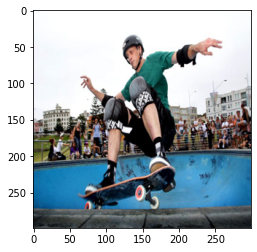

In [ ]:
path = 'https://pixel.nymag.com/imgs/daily/selectall/2018/02/12/12-tony-hawk.w710.h473.jpg'
get_caption(path)

a a a a a a a a a a a a a a a a a 

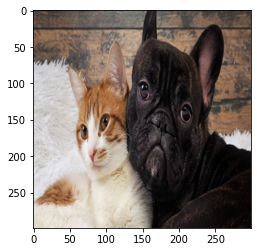

In [ ]:
path = 'http://ccanimalclinic.com/wp-content/uploads/2017/07/Cat-and-dog-1.jpg'
get_caption(path)

a a a a a a a a a a a a a a a a a 

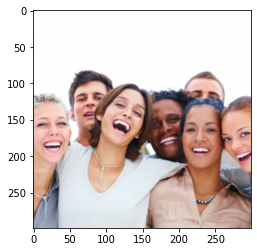

In [ ]:
path = 'https://www.authenticityassociates.com/wp-content/uploads/2019/06/PursuitofHappiness123-e1561125279583.jpg'
get_caption(path)